# 影评分类：二分类问题示例

二分类问题是最常见的一类机器学习问题。本例中，根据影评文本将其划分为正面或负面

## IMDB数据集

In [1]:
from tensorflow.keras.datasets import imdb

2024-08-18 17:44:36.974441: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


num_words=10000为仅保留训练数据中前10000个最长出现的单词。

In [2]:
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

train_labels和test_labels都是由0和1组成的列表，其中0代表负面，1代表正面

In [3]:
# 将评论解码为文本
word_index = imdb.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
decoded_review = " ".join([reverse_word_index.get(i - 3, "?") for i in train_data[0]])
decoded_review

"? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you th

## 准备数据

不能直接将整数列表传入神经网络。整数列表的长度各不相同，但神经处理的是大小相同的数据批量。需要将列表转换成**张量**，转换方法有以下两种：
- 填充列表，使其长度相等，再将列表转换成形状为`(samples, max_length)`的整数张量，然后在模型第一层使用能处理这种张量的层`(embedding层)`。
- 对列表进行**multi-hot编码**，将其转换成由0和1组成的向量。eg：将序列[8,5]转换成一个10000维向量，只有索引8和5对应的元素是1，其余元素都是0。然后，模型第一层可以用Dense层，它能够处理浮点数向量数据。

In [4]:
# 用multi-hot编码对整数序列进行编码
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        for j in sequence:
            results[i, j] = 1.
    return results

# 将训练数据向量化
x_train = vectorize_sequences(train_data)
# 将测试数据向量化
x_test = vectorize_sequences(test_data)

In [5]:
x_train[0]

array([0., 1., 1., ..., 0., 0., 0.])

In [6]:
# 将训练标签向量化
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

## 构建模型

输入数据是向量，而标签是标量(1和0)，这是最简单的一类问题。有一类模型在这种问题上的表现很好，就是带有relu激活函数的密集连接层（Dense）的简单堆叠。
对于Dense层的这种堆叠，需要做出以下两个关键的架构决策：
- 神经网络有多少层
- 每层有多少个单元

以下Dense层使用下列架构：
- 两个中间层，每层16个单元
- 第三层输出一个标量预测值，代表当前评论的情感类别

模型的架构示意图如下：

![模型架构示意图](images/影评二分类模型架构示意图.png "影评二分类模型架构示意图")

In [7]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Dense(16, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

每个带有**relu激活函数**的Dense层都实现了下列张量运算 <br>
`output = relu(dot(input, W) + b)` <p>
16个单元对应的权重矩阵W的形状为`(input_dimension, 16)`，与W做点积相当于把输入数据投影到16维表示空间中。可以将表示空间的维度直观理解为“模型学习内部表示时所拥有的自由度”。单元越多（表示空间的维度越高），模型就能学到更加复杂的表示，但模型计算代价也变得更大，并可能导致学到不必要的模式。<p>
中间层使用**relu**作为激活函数，最后一层使用**sigmoid**激活函数，以便输出一个介于0和1之间的概率值。
- relu函数将所有负值归零；
- sigmoid函数则将任意值“压缩”到[0,1]区间内，其输出可以看做概率值。<p>
![relu激活函数](images/relu激活函数.png "relu激活函数")<p>
![sigmoid激活函数](images/sigmoid激活函数.png "sigmoid激活函数")

### 什么是激活函数？为什么要使用激活函数？

如果没有像relu这样的激活函数（也叫**非线性激活函数**），Dense层就只包含两个线性运算，即点积与加法：<br>
`output = dot(input, W) + b` <p>
这样的层只能学习输入数据的**线性变换***（仿射变换）：该层的**假设空间**是从输入数据到16维空间所有可能得线性变换集合。这种假设空间非常受限，无法利用多个表示层的优势，因为多个线性层堆叠实现的仍是线性运算，增加层数并不会扩展假设空间。<p>
为了得到更丰富的假设空间，从而充分利用多层表示的优势，**需要引入非线性**，也就是激活函数。

### 选择损失函数和优化器

对于二分类问题的损失函数选择，模型输出是一个概率值（模型最后一层只有一个单元并使用sigmoid激活函数），所以最好使用`binary_crossentropy`（二元交叉熵）损失函数。对于输出概率值的模型，交叉熵通常是最佳选择。<p>
优化器，将使用`rmsprop`。对与几乎所有问题，它通常都是很好的默认选择

In [8]:
# 编译模型
model.compile(
    optimizer="rmsprop",
    loss="binary_crossentropy",
    metrics=["accuracy"])

## 验证你的方法

In [9]:
# 留出验证集
x_val = x_train[:10000]
partial_x_train = x_train[10000:]
y_val = y_train[:10000]
partial_y_train = y_train[10000:]

### 训练模型

In [10]:
# 训练模型
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data = (x_val, y_val))

Epoch 1/20
30/30 [==============================] - 2s 36ms/step - loss: 0.5094 - accuracy: 0.7724 - val_loss: 0.4354 - val_accuracy: 0.8169
Epoch 2/20
30/30 [==============================] - 0s 9ms/step - loss: 0.3122 - accuracy: 0.8951 - val_loss: 0.3079 - val_accuracy: 0.8847
Epoch 3/20
30/30 [==============================] - 0s 8ms/step - loss: 0.2330 - accuracy: 0.9227 - val_loss: 0.2955 - val_accuracy: 0.8818
Epoch 4/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1875 - accuracy: 0.9363 - val_loss: 0.2794 - val_accuracy: 0.8875
Epoch 5/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1596 - accuracy: 0.9485 - val_loss: 0.2982 - val_accuracy: 0.8837
Epoch 6/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1365 - accuracy: 0.9568 - val_loss: 0.3092 - val_accuracy: 0.8762
Epoch 7/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1189 - accuracy: 0.9623 - val_loss: 0.3078 - val_accuracy: 0.8845
Epoch 8/20
30/30 [=

调用`model.fit()`返回了一个**History对象**，这个对象有一个名为history的成员，它是一个字典，包含训练过程的全部数据。

In [11]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

### 使用Matplotlib绘制数据变化图

#### 绘制训练损失和验证损失

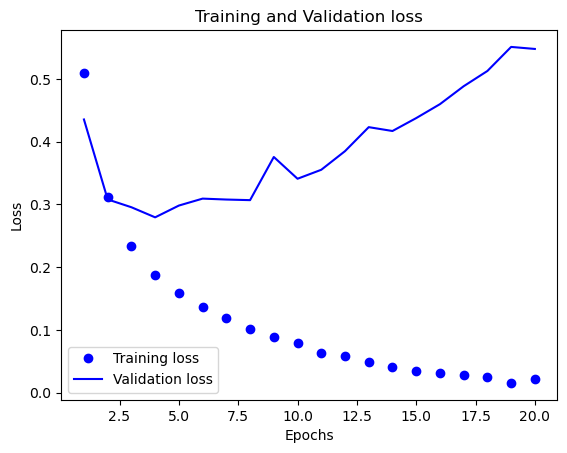

In [12]:
import matplotlib.pyplot as plt
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
# bo表示"蓝色圆点"
plt.plot(epochs, loss_values, "bo", label="Training loss")
# b表示"蓝色实线"
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

#### 绘制训练精度和验证精度

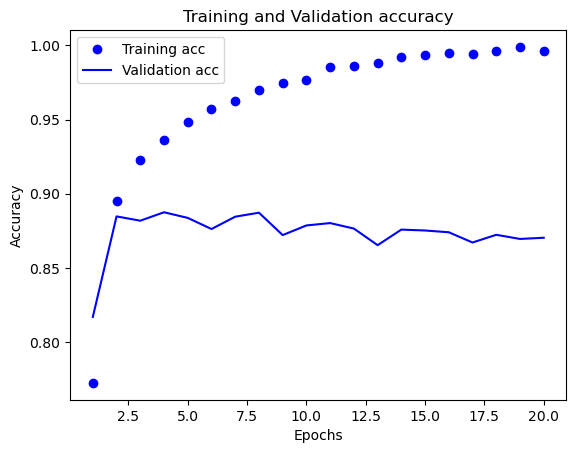

In [13]:
plt.clf()
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and Validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

## 利用训练好的模型对新数据进行预测

In [14]:
model.predict(x_test)

782/782 [==============================] - 1s 830us/step


array([[0.02922997],
       [0.9999999 ],
       [0.7995538 ],
       ...,
       [0.00368623],
       [0.01071579],
       [0.9372384 ]], dtype=float32)

In [15]:
results = model.evaluate(x_test, y_test)

782/782 [==============================] - 1s 815us/step - loss: 0.5919 - accuracy: 0.8583


In [16]:
results

[0.5919103026390076, 0.8583199977874756]

# 新闻分类：多分类问题示例

上面介绍了如何用密集连接神经网络将向量输入划分为两个互斥的类别。但如果类别不止两个，要如何训练模型？</p>
将构建一个模型，把路透社新闻划分到46个互斥的主题中。由于有多个类别，因此这是一个**多分类**问题。具体来说这是一个**单标签、多分类**问题。如果是每个数据点可以划分到多个类别（主题）中，那就是**多标签、多分类**问题。</p>

## 路透社数据集

### 加载路透社数据集

In [18]:
from tensorflow.keras.datasets import reuters
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

## 准备数据

### 使用multi-hot对数据进行编码

In [19]:
# 将训练数据向量化
x_train = vectorize_sequences(train_data)
# 将测试数据向量化
x_test = vectorize_sequences(test_data)

### 标签向量化

将标签向量化有两种方法：
- 将标签列表转换成一个整数张量。
- 使用one-hot编码。one-hot编码是分类数据的一种常见格式，也叫**分类编码**

In [20]:
# 使用one-hot编码将标签向量化
def to_one_hot(labels, dimension=46):
    results = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        results[i, label] = 1
    return results

# 将训练标签向量化
y_train = to_one_hot(train_labels)
y_test = to_one_hot(test_labels)

#### Keras内置方法实现one-hot编码

In [21]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(train_labels)
t_test = to_categorical(test_labels)

## 构建模型

In [22]:
# 模型定义
model = keras.Sequential([
    layers.Dense(64, activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dense(46, activation="softmax")])

关于模型架构应注意以下两点：
1. 模型的最后一层是大小为46的Dense层。也就是说，对于每个输入样本，神经网络都会输出一个46维向量。这个向量的每个元素（每个维度）代表不同的输出类别。
2. 最后一层使用了`softmax`激活函数。模型将输出一个在46个输出类别上的**概率分布** ———— 对于每个输入样本，模型都会生成一个46维输出向量，其中`output[i]`是样本属于第i个类别的概率。46个概率值的总和为1.

### 选择损失函数

对于本次例子，最好的损失函数是`categorical_crossentropy`（分类交叉熵）。它衡量的是两个概率分布之间的距离，这里两个概率分布分别是模型输出的概率分布和标签的真实分布。我们训练模型将这两个分布的距离最小化，从而让输出结果尽可能接近真实标签。

In [23]:
# 编译模型
model.compile(optimizer="rmsprop", 
              loss="categorical_crossentropy", 
              metrics=["accuracy"])

## 验证你的方法

### 留出验证集

In [24]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]
y_val = y_train[:1000]
partial_y_train = y_train[1000:]

### 训练模型

In [25]:
history = model.fit(partial_x_train, 
                    partial_y_train, 
                    epochs=20, 
                    batch_size=512, 
                    validation_data=(x_val, y_val))

Epoch 1/20
16/16 [==============================] - 1s 26ms/step - loss: 2.7551 - accuracy: 0.4951 - val_loss: 1.8505 - val_accuracy: 0.6300
Epoch 2/20
16/16 [==============================] - 0s 16ms/step - loss: 1.5383 - accuracy: 0.6848 - val_loss: 1.3632 - val_accuracy: 0.6920
Epoch 3/20
16/16 [==============================] - 0s 14ms/step - loss: 1.1696 - accuracy: 0.7482 - val_loss: 1.1884 - val_accuracy: 0.7300
Epoch 4/20
16/16 [==============================] - 0s 14ms/step - loss: 0.9580 - accuracy: 0.7964 - val_loss: 1.0646 - val_accuracy: 0.7680
Epoch 5/20
16/16 [==============================] - 0s 15ms/step - loss: 0.7941 - accuracy: 0.8325 - val_loss: 0.9898 - val_accuracy: 0.7970
Epoch 6/20
16/16 [==============================] - 0s 15ms/step - loss: 0.6665 - accuracy: 0.8568 - val_loss: 0.9364 - val_accuracy: 0.8080
Epoch 7/20
16/16 [==============================] - 0s 14ms/step - loss: 0.5588 - accuracy: 0.8807 - val_loss: 0.9021 - val_accuracy: 0.8110
Epoch 8/20
16

### 绘制训练损失和验证损失

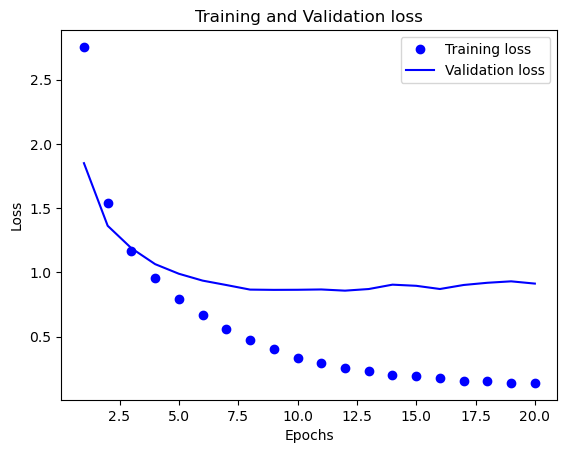

In [26]:
plt.clf()
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

### 绘制训练精度和验证精度

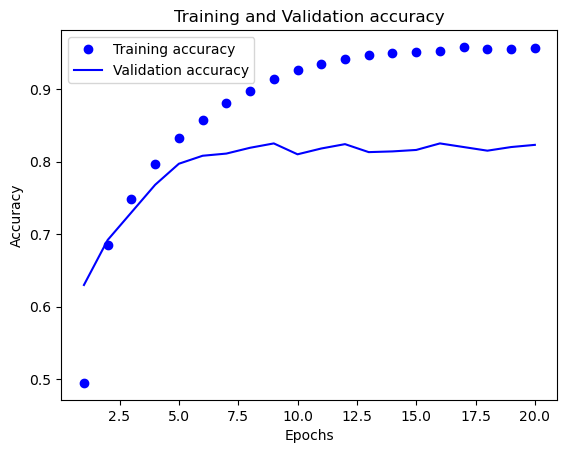

In [27]:
plt.clf()
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and Validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### 模型评估

In [30]:
results = model.evaluate(x_test, y_test)
results

71/71 [==============================] - 0s 1ms/step - loss: 1.0070 - accuracy: 0.7992


[1.0069724321365356, 0.799198567867279]

### 随机精度验证

In [31]:
import copy
test_labels_copy = copy.copy(test_labels)
np.random.shuffle(test_labels)
hits_array = np.array(test_labels) == np.array(test_labels_copy)
hits_array.mean()

0.19278717720391808

## 对新数据进行预测

In [32]:
predictions = model.predict(x_test)

71/71 [==============================] - 0s 1ms/step


In [33]:
predictions[0].shape

(46,)

In [34]:
np.sum(predictions[0])

1.0

In [35]:
np.argmax(predictions[0])

3

## 处理标签和损失的另一种方法

使用另一种编码标签的方法：将其转换为整数张量。

In [37]:
y_train = np.array(train_labels)
y_test = np.array(test_labels)

### 损失函数的选择

对于将标签转换为整数张量的方法，在模型构建上，唯一需要改变的就是**损失函数的选择**。
- one-hot标签使用的损失函数是categorical_crossentropy，标签应遵循分类编码。
- 整数标签使用的损失函数是sparse_categorical_crossentropy（稀疏分类交叉熵）损失函数。

In [38]:
model.compile(optimizer="rmsprop", 
              loss="sparse_categorical_crossentropy", 
              metrics=["accuracy"])

# 预测放假：标量回归问题示例

常见监督学习问题：
- **分类问题**，其目标是预测输入数据点对应的单一离散标签。
- **回归问题**，预测的是一个连续值，而不是离散标签。比如：根据气象数据预测明日气温，或者根据软件说明书预测完成软件项目所需时间。<p>

**注意**：不要将**回归**问题与**logistic回归**算法混为一谈。logistic回归不是回归算法，而是分类算法。

## 波士顿房价数据集

### 加载波士顿房价数据集

In [39]:
from tensorflow.keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = (boston_housing.load_data())

57026/57026 [==============================] - 1s 11us/step


In [40]:
train_data.shape

(404, 13)

In [41]:
test_data.shape

(102, 13)

## 准备数据

将取值范围差异很大的数据输入到神经网络中，是不可行的。模型可能会自动适应这种取值范围不同的数据，但这肯定会让学习变得更加困难。<p>
对于这类数据，普遍采用的**最佳处理方法**是对每个特征进行标准化，即对于输入数据的每个特征（输入数据矩阵的每一列），减去特征平均值，再除以标准差，这样得到的特征平均值为0，标准差为1。**用NumPy可以很容易实现数据标准化**

In [42]:
# 计算特征平均值
mean = train_data.mean(axis=0)
# 每个特征减去平均值
train_data -= mean
# 计算特征标准差
std = train_data.std(axis=0)
# 每个特征除以特征标准差
train_data /= std

# 测试数据集
test_data -= mean
test_data /= std

**注意**，对测试数据集进行标准化的，特征平均值和特征标准差，也要使用训练数据集中计算得到的。在深度学习工作流程中，***不能使用在测试数据上计算得到的任何结果***，即使是将数据标准化这么简单的事情也不行。

## 构建模型

In [43]:
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(1)])
    model.compile(optimizer="rmsprop", 
                  loss="mse", 
                  metrics=["mae"])
    return model

模型的最后一层只有一个单元且没有激活函数，它是一个线性层。这是标量回归（标量回归是预测单一连续值的回归）的典型设置。添加激活函数将限制输出范围。<p>
**注意**，编译模型用的是mse损失函数，即**均方误差（mean squared error, MSE）**，预测值与目标值之差的平方。这是回归问题的常用的损失函数。 <p>
在训练过程中还要监控一个新指标：**平均绝对误差（mean absolute error, MAE）**。它是预测值与目标值之差的绝对值。eg：这个问题的MAE等于0.5，就表示预测放假与实际价格平均相差500美元。

## 利用K折交叉验证来验证你的方法

当数据点很少时，最佳做法就是使用**K折交叉验证**。
![K折交叉验证](images/K折交叉验证.png "K折交叉验证") <p>
这样方法将可用数据划分为K个分区（K通常取4或5），实例化K个相同的模型，然后将每个模型在K-1个分区上训练，并在剩下的一个分区上进行评估。模型的验证分数等于这K个验证分数的平均值。

In [46]:
k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []
for i in range(k):
    print(f"Processing fold #{i}")
    # 准备验证数据：第k个分区的数据
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    # 准备训练数据：其余所有分区的数据
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples], train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples], train_targets[(i + 1) * num_val_samples:]],
        axis=0)
    # 构建Keras模型
    model = build_model()
    # 训练模型（静默模式，verbose=0）
    model.fit(partial_train_data, 
              partial_train_targets, 
              epochs=num_epochs, 
              batch_size=16, 
              verbose=0)
    # 在验证数据上评估模型
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

# 运行结果如下
print(all_scores)
print(np.mean(all_scores))

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3
[2.0462772846221924, 2.5072996616363525, 2.466883897781372, 2.3708972930908203]
2.3478395342826843


### 记录模型每轮的表现

为了记录模型每轮的表现，需要修改训练循环，在每轮都保存每折的验证分数。

In [48]:
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print(f"Processing fold #{i}")
    # 准备验证数据：第k个分区的数据
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    # 准备训练数据：其余所有分区的数据
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples], train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples], train_targets[(i + 1) * num_val_samples:]],
        axis=0)
    model = build_model()
    history = model.fit(partial_train_data, 
                        partial_train_targets, 
                        validation_data=(val_data, val_targets), 
                        epochs=num_epochs, 
                        batch_size=16, 
                        verbose=0)
    mae_history = history.history["val_mae"]
    all_mae_histories.append(mae_history)

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3


#### 计算每轮所有折MAE的平均值

In [50]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

#### 绘制验证MAE曲线

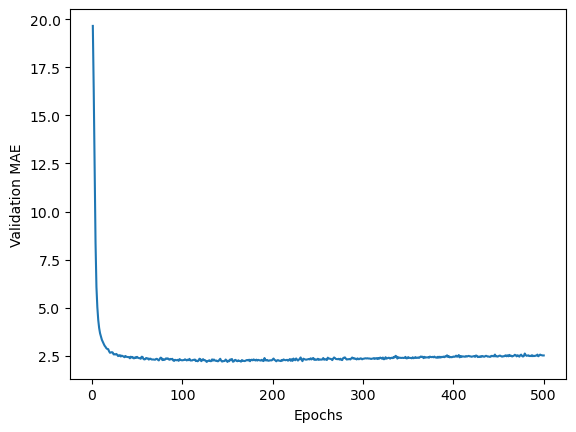

In [51]:
plt.clf()
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

#### 绘制验证MAE曲线（剔除前10个数据点）

由于比例问题，前几轮的验证MAE远大于后面的轮次。我们忽略前10个数据点，因为它们的取值范围与曲线上的其他点不同。

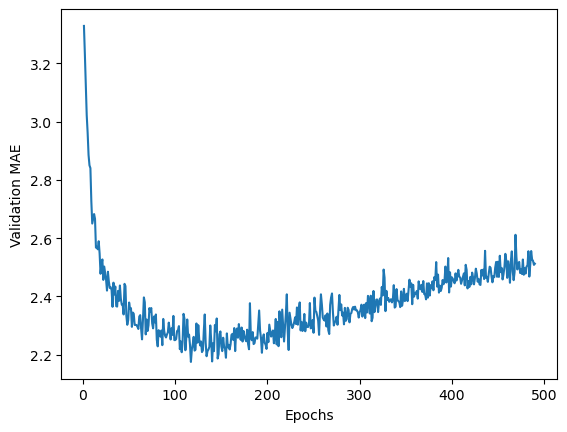

In [52]:
truncated_mae_history = average_mae_history[10:]
plt.clf()
plt.plot(range(1, len(truncated_mae_history) + 1), truncated_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

#### 训练最总模型

In [53]:
model = build_model()
model.fit(train_data, train_targets, epochs=130, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)
print(test_mae_score)

4/4 [==============================] - 0s 1ms/step - loss: 15.1552 - mae: 2.5556
2.555551767349243


## 对新数据进行预测

In [54]:
predictions = model.predict(test_data)
predictions[0]

4/4 [==============================] - 0s 943us/step


array([9.305989], dtype=float32)